# Random Forest Classifier To Predict Plate Appearance Outcome For Shohei Ohtani (6 Class)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("ohtani_stats_2024.csv")

In [4]:
df.head()

,pitcher,events,home_team,away_team,pitch_name,release_speed,launch_speed,launch_angle,hit_distance_sc,bb_type,release_pos_x,release_pos_y,zone,p_throws,balls,strikes,outs_when_up,inning
0,543037,field_out,NYY,LAD,Knuckle Curve,83.3,79.1,7.0,102.0,ground_ball,-2.52,54.37,13.0,R,1,1,0,7
1,543037,strikeout,NYY,LAD,Knuckle Curve,87.3,NaN,NaN,NaN,NaN,-2.74,54.10,13.0,R,1,2,1,5
2,543037,field_out,NYY,LAD,Changeup,90.4,88.2,29.0,317.0,fly_ball,-2.77,54.20,13.0,R,0,2,2,3
3,596133,catcher_interf,NYY,LAD,Changeup,89.7,NaN,NaN,NaN,NaN,-1.63,54.56,4.0,R,0,0,1,8
4,543037,field_out,NYY,LAD,4-Seam Fastball,95.6,93.2,45.0,289.0,fly_ball,-2.76,54.32,5.0,R,0,0,0,1


In [5]:
# Map hit type to corresponding label
hit_mapping = {
    'single': 1,
    'double': 2,
    'triple': 3,
    'home_run': 4,
    'walk': 5,
}

In [6]:
# Grabs opponent team from data
def get_opponent(row):
    if row['home_team'] == 'LAD':
        return row['away_team']
    else:
        return row['home_team']

In [7]:
# Maps hit type to it's label, everything not a hit is a 0
df['target'] = df['events'].apply(lambda x: hit_mapping.get(x.lower(), 0))

In [8]:
# Gets opponent team
df['opponent_team'] = df.apply(get_opponent, axis=1)

In [9]:
df.head()

,pitcher,events,home_team,away_team,pitch_name,release_speed,launch_speed,launch_angle,hit_distance_sc,bb_type,release_pos_x,release_pos_y,zone,p_throws,balls,strikes,outs_when_up,inning,target,opponent_team
0,543037,field_out,NYY,LAD,Knuckle Curve,83.3,79.1,7.0,102.0,ground_ball,-2.52,54.37,13.0,R,1,1,0,7,0,NYY
1,543037,strikeout,NYY,LAD,Knuckle Curve,87.3,NaN,NaN,NaN,NaN,-2.74,54.10,13.0,R,1,2,1,5,0,NYY
2,543037,field_out,NYY,LAD,Changeup,90.4,88.2,29.0,317.0,fly_ball,-2.77,54.20,13.0,R,0,2,2,3,0,NYY
3,596133,catcher_interf,NYY,LAD,Changeup,89.7,NaN,NaN,NaN,NaN,-1.63,54.56,4.0,R,0,0,1,8,0,NYY
4,543037,field_out,NYY,LAD,4-Seam Fastball,95.6,93.2,45.0,289.0,fly_ball,-2.76,54.32,5.0,R,0,0,0,1,0,NYY


In [10]:
# Drop columns we don't want
X = df.drop(columns=['events', 'launch_speed', 'launch_angle', 'hit_distance_sc', 'bb_type','home_team', 'away_team', 'target', 'p_throws'])

In [11]:
# Assign an id to the pitch name
le = LabelEncoder()

X['pitch_id'] = le.fit_transform(X['pitch_name'])
X = X.drop(columns=['pitch_name'])

In [12]:
# Assign an id to the opponent team
X['opponent_team_id'] = le.fit_transform(X['opponent_team'])
X = X.drop(columns=['opponent_team'])

In [13]:
X

,pitcher,release_speed,release_pos_x,release_pos_y,zone,balls,strikes,outs_when_up,inning,pitch_id,opponent_team_id
0,543037,83.3,-2.52,54.37,13.0,1,1,0,7,4,17
1,543037,87.3,-2.74,54.10,13.0,1,2,1,5,4,17
2,543037,90.4,-2.77,54.20,13.0,0,2,2,3,1,17
3,596133,89.7,-1.63,54.56,4.0,0,0,1,8,1,17
4,543037,95.6,-2.76,54.32,5.0,0,0,0,1,0,17
...,...,...,...,...,...,...,...,...,...,...,...
823,663562,NaN,NaN,NaN,NaN,0,0,1,3,11,7
824,596295,NaN,NaN,NaN,NaN,0,0,0,1,11,7
825,595881,NaN,NaN,NaN,NaN,3,0,2,5,11,6
826,471911,NaN,NaN,NaN,NaN,3,0,1,1,11,6


In [14]:
# Create target vector
y = df['target']

In [15]:
y

0      0
1      0
2      0
3      0
4      0
      ..
823    1
824    1
825    5
826    5
827    1
Name: target, Length: 828, dtype: int64

In [16]:
# Perform 5-fold cross validation
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

cv_results = cross_validate(rf_model, X, y, cv=5, scoring=scoring)

C:\Users\tonyg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tonyg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tonyg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tonyg\anaconda3\Lib\site-packag

In [17]:
# Print CV results
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean():.4f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean():.4f}")
print(f"Mean F1 Score: {cv_results['test_f1_macro'].mean():.4f}")

Mean Accuracy: 0.6836
Mean Precision: 0.2824
Mean Recall: 0.2815
Mean F1 Score: 0.2612


Accuracy is misleading here because of the class imbalance

In [18]:
# Train and test with 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((662, 11), (662,), (166, 11), (166,))

In [20]:
# Random Forest model with class balancing to handle class imbalance
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [21]:
y_pred = rf_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.67      0.93      0.78       104
           1       0.33      0.09      0.14        23
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        12
           5       0.87      0.72      0.79        18

    accuracy                           0.67       166
   macro avg       0.31      0.29      0.28       166
weighted avg       0.56      0.67      0.59       166



C:\Users\tonyg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tonyg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tonyg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


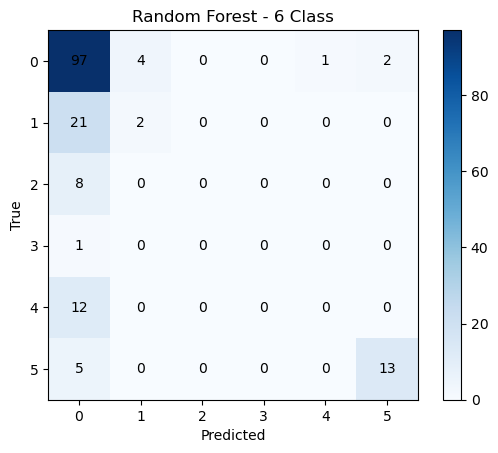

In [22]:
# Print classification report
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Add colorbar
plt.colorbar(im)

# Add labels
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Random Forest - 6 Class')

# Add numbers on each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()

In [23]:
# Print class distribution to demonstrate class imbalance
class_distribution = df['target'].value_counts()
class_distribution

target
0    517
1    115
5     90
4     58
2     40
3      8
Name: count, dtype: int64